<h1>Let's take a look under the hood</h1>
In order to get a better look at the data, I'm going to dig in a little bit to see what questions I think need to be asked and answered with this data set


In [219]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, mean_absolute_error

%matplotlib inline

There are three datasets in the Seattle Data from Airbnb: reviews, listings and calendar. I'm going to import each of these and take a look and see what questions I think are important given the data.

In [220]:
reviews = pd.read_csv('./seattle/reviews.csv')
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [221]:
listings = pd.read_csv('./seattle/listings.csv')
listings.columns

#Printing out the columns here because there are 92 of them! That's a lot and I probably want to cut that down!

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [222]:
listings.price.head()

0     $85.00
1    $150.00
2    $975.00
3    $100.00
4    $450.00
Name: price, dtype: object

In [223]:
calendar = pd.read_csv('./seattle/calendar.csv')
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


<h4>What can we use this data for? Or what questions can we ask about this data?</h4>

Question 1: How many times do people change the price of their listing? 
- I know that I personally tried changing the listing of my house on Airbnb for an event, but I'm not sure how much this actually happens! I think this

Question 2: How does the amount of reviews for a listing affect the price of a listing?
- I rarely keep track of the amount of reviews for things when I buy them, just the overall rating! I know that this is a weird psychological thing, but it could definitely affect the price! It looks like Airbnb even keeps track of the reviews per month so that sounds important.

Question 3: Can we predict the price of a property based on the reviews given? 
- I know that Airbnb probably does a lot of this, so I'm curious if this data will be enough! This should be fun! I'm currently a bit ahead and am coming back to complete this project, so I've done some with the nltk python package!



<h2>Question 1</h2>
<h4>How many times do people change the price of their listing?</h4>

I think this should be a little bit of a data wrangling exercise, but it should show us some cool things! Let's pick up where we left off in the data wrangling to get the pieces of info we needed.

It's interesting here that we have quite a few NaNs for the price in the calendar data. We maybe should save those in a separate dataframe, but it looks like that's when they're taken off the market. Let's double check on that!

In [224]:
# Let's get a starting point for what our data actually has!
print( "Listings shape: ",listings.shape)
print("Reviews shape: ", reviews.shape)
print("Calendar shape: ",calendar.shape)

Listings shape:  (3818, 92)
Reviews shape:  (84849, 6)
Calendar shape:  (1393570, 4)


In [225]:
# let's create a subset of the calendar when the listing goes off the market that we can use later.
unavailable_calendar = calendar[calendar.available == 'f']
unavailable_calendar.shape

(459028, 4)

Well, that's a lot of missing data. I assume that there's a lot of people that take their house off the market, but I'm not sure how many. Let's see how this works a little bit more. It's not part of my initial questions but it will help us understand the pricing a little bit more!

In [226]:
available_calendar = calendar[calendar.available == 't']
print("Unavailable without price: {}".format(unavailable_calendar['price'].isna().sum()))
print("Available without price: {}".format(available_calendar['price'].isna().sum()))

Unavailable without price: 459028
Available without price: 0


Gotcha! So there will always be a price for an available property. They remove the old price for a property when its off the market! They probably just save that elsewhere.

First thing let's see how often users change their price at all! This will be important!

In [227]:
# find all the new prices!
unique_prices_s = available_calendar.groupby('listing_id')['price'].nunique()
unique_prices = unique_prices_s.to_frame()
count_changed_listings = unique_prices[unique_prices['price'] > 1].shape[0]

print("Number of unique prices: {}".format(count_changed_listings))
print("Total available listings: {}".format(unique_prices.shape[0]))
print("Percent that change: {}".format(count_changed_listings/unique_prices.shape[0]))

Number of unique prices: 2115
Total available listings: 3723
Percent that change: 0.5680902497985496


That's a pretty good amount of listings that change their price! Let's graph it so we can see how much they actually change!

In [228]:
calendar_unique_data = pd.value_counts(unique_prices_s)
calendar_unique_data.head()

1    1608
2     802
3     268
4     138
5     130
Name: price, dtype: int64

([<matplotlib.axis.XTick at 0x15759546fd0>,
 <a list of 9 Text xticklabel objects>)

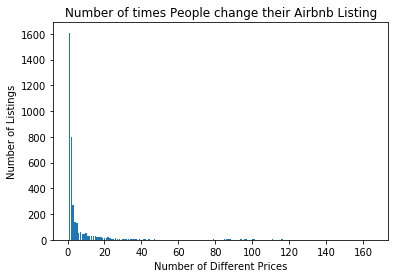

In [229]:
plt.bar(calendar_unique_data.index, calendar_unique_data.values)
plt.title("Number of times People change their Airbnb Listing")
plt.xlabel("Number of Different Prices")
plt.ylabel("Number of Listings")
plt.xticks(np.arange(0,180,step=20))

In [230]:
unique_prices[unique_prices['price'] > 20 ].shape

(287, 1)

Based on this graph it looks like there are only a few people that are changing their price very much. A majority of the listings changed less than 20 times! To be fair, I'm only looking at the number of unique prices. So technically, if someone is moving back and forth between two prices that would be a different graph to look at. I think this is a decent look into the data and this graph should be good to bring to a business meeting and chat about! I was initially hopeful that I could do something cool and figure out if everyone in Seattle would change the price of their house around a certain event like they do in Austin for SXSW and Austin City Limits music festival. But I wasn't able to find anything on the web for Seattle that was similar! I think when you have a big city like Seattle there's always things going on and the listings are just more expensive!

<h2>Question 2</h2>
<h4>How does the amount of reviews affect the price of a listing</h4>

I personally know that it's difficult to get people to come to a restaurant without any reviews of the place! So sometimes folks might change the price of their house based on the number of reviews!


First things first, let's merge the calendar data pricing data with the reviews! I'm going to drop the columns that aren't necessary from both dataframes first!


In [231]:
reviews.shape
reviews.drop(columns=["id", "reviewer_id", "reviewer_name", "date"], inplace=True)

In [232]:
prices = available_calendar.drop(columns=['available', 'date'])
prices.drop_duplicates(subset='price', keep="first", inplace=True)
prices.head()

,listing_id,price
0,241032,$85.00
365,953595,$125.00
452,953595,$154.00
453,953595,$164.00
454,953595,$165.00


In [233]:
reviews_prices = pd.merge(reviews, prices, on="listing_id", how="outer")
reviews_prices.head()

,listing_id,comments,price
0,7202016,Cute and cozy place. Perfect location to every...,NaN
1,7202016,Kelly has a great room in a very central locat...,NaN
2,7202016,"Very spacious apartment, and in a great neighb...",NaN
3,7202016,Close to Seattle Center and all it has to offe...,NaN
4,7202016,Kelly was a great host and very accommodating ...,NaN


In [234]:
reviews_prices.shape

(99854, 3)

Welp! It looks like at least some of these listings don't have a price associated with them anymore! Maybe they are older listings that are no longer available. Let's take out all of the ones without prices!

In [235]:
reviews_prices.dropna(axis=0, how='any', subset={'price'}, inplace=True)
reviews_prices.head()
reviews_prices.shape


(17591, 3)

Woah that took out a lot of reviews! Well I'm still hoping to at least answer the question I initially asked, but this will be an important thing for me to note in my analysis later! Let's make another column with the count of the reviews for that listing!

In [236]:
reviews_prices["count"] = reviews_prices.groupby('listing_id')['listing_id'].transform("count")


In [237]:
reviews_prices.head()


,listing_id,comments,price,count
2552,7207641,Joe and Anna are very friendly. They made us f...,$348.00,5
2553,7207641,"Listing was accurate, host even left neighborh...",$348.00,5
2554,7207641,Great house in a great neighborhood! Everythin...,$348.00,5
2555,7207641,Great house! Top notch location and appliances...,$348.00,5
2556,7207641,Very clean and organized. The hosts provided ...,$348.00,5


Hmm I'm curious if the price is actually a string and not an integer here. If we're trying to graph and see if there is a correlation that will be important that it's a number!

In [238]:
type(reviews_prices["price"].iloc[0])

str

Nailed it! I found you! You cannot hide from me! Ok, ok I'll clean it up now.

In [239]:
reviews_prices['price'] = pd.to_numeric(reviews_prices['price'].map(lambda x: x.strip('$').replace(',','')))

In [240]:
reviews_prices_no_dupes = reviews_prices.drop_duplicates(subset="listing_id")

With this dataframe we can make a pretty cool chart!

Text(0, 0.5, 'Price')

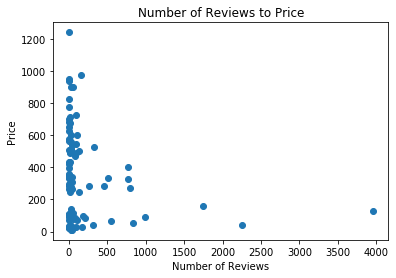

In [241]:
plt.scatter(reviews_prices_no_dupes["count"], reviews_prices_no_dupes["price"])

#plt.MaxNLocator(3)
plt.title("Number of Reviews to Price")
plt.xlabel("Number of Reviews")
plt.ylabel("Price")


Well that didn't go as planned, it looks like the number of reviews don't really affect the price. But now we know! I know that the number of reviews is important to some people when they're looking at products online, but it looks like the actual count of them isn't that important!

<h2>Question 3</h2>
<h4>Can we predict the price of a property based on the reviews?</h4>

Plan of attack:

1. I'm going to use some NLP word tokenization stuff that I recall from the Data Engineering course! 
2. I'm going to run these through a pipeline.
3. I'm going to check my accuracy there and if I can improve anything via GridSearch I'm going to try that!

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords'])
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from nltk.corpus import stopwords

def tokenize(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english')) 
    lemmatizer = WordNetLemmatizer()
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [lemmatizer.lemmatize(w.lower().strip()) for w in tokens]
    return tokens

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nevin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nevin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nevin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestRegressor())
])

    

In [ ]:
from sklearn.model_selection import train_test_split
reviews_prices.dropna(inplace=True)
X = reviews_prices['comments']
Y = reviews_prices['price']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

In [ ]:
pipeline.fit(X_train, y_train)

c:\python\python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [ ]:
y_preds = pipeline.predict(X_test)

In [ ]:
mean_squared_error(y_test, y_preds)

In [ ]:
from math import sqrt
rmse = sqrt(mean_squared_error(y_test, y_preds))
rmse

In [ ]:
y_preds[:10]

In [ ]:
y_test.head(10)

In [ ]:
r2_score(y_test, y_preds)

In [ ]:
y_preds.shape

In [ ]:
mean_absolute_error(y_test, y_preds)

Wow! That's pretty good I think! I want to try and fine-tune this a little bit more. But this is a great starting point! This means that we were off by an average of $49 dollars per prediction. I would think that our prediction would be much worse actually! 

Looking at the graph from question 2, it looks like outliers here could really push it one direction or another. The root mean squared error for example is almost double our mean absolute error, which also tells me that the outliers are really affecting our error.

I want to try to get even better! Never give up, never surrender!

While googling around about this project I found this <a href="https://towardsdatascience.com/detecting-bad-customer-reviews-with-nlp-d8b36134dc7e">article</a> which uses an nltk package called SentimentIntensityAnalyzer.
  
I think I'm going to try and use that instead! Why not! Actually, let's see if we can compare a bunch of different pipelines! First, then I'll change the tokenize function to see if it will work!

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

pipeline_knn = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('knn', RandomForestClassifier())
])

pipeline_rf = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestRegressor())
])

pipeline_lin = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearRegression())
])


def compare_model_residuals(models,X,y):
    f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)
    plt.title('Plotting residuals using training (blue) and test (green) data')
    mean_sq_e = []
    for m, ax in ((models[0], ax1),(models[1], ax2),(models[2], ax3)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        m[0].fit(X_train, y_train)
        y_preds_train = m[0].predict(X_train)
        y_preds_test = m[0].predict(X_test)
        ax.scatter(m[0].predict(X_train), y_preds_train - y_train,c='#2B94E9',s=40,alpha=0.5)
        ax.scatter(m[0].predict(X_test), y_preds_test - y_test,c='#94BA65',s=40)
        ax.hlines(y=0, xmin=0, xmax=100)
        ax.set_title(m[1])
        ax.set_ylabel('Residuals')
        mean_sq_e.append("Model {} with absolute error {}".format(m[1], str(mean_absolute_error(y_test,y_preds_test))))
    plt.xlim([20,70])
    plt.ylim([-100,100])  
    plt.show()
    print(mean_sq_e)
models = np.array([(pipeline_rf,'Random Forest'), (pipeline_lin,'Linear Regression'), (pipeline_knn,'KNearest Regression')])
compare_model_residuals(models, X, Y)



Well the error looks best with Linear Regression! I like this residuals function as it helps me figure out where and how I missed! Next I want to try to use a sentiment analyzer for tokens instead of tfidf and count vectorizer

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion

class ReviewSentiment(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""
    def fit(self, X, y=None):
        return self

    def transform(self, data):
        analyser = SentimentIntensityAnalyzer()
        polarity_list = [analyser.polarity_scores(comment) for _,comment in data.iteritems()]
        return pd.DataFrame(polarity_list)

pipeline_sent = Pipeline([
    ('polarity', ReviewSentiment()),
    ('clf', RandomForestRegressor())
])

pipeline_sent.fit(X_train, y_train)
    
y_preds = pipeline.predict(X_test)    

mean_absolute_error(y_test, y_preds)

In [ ]:
r2_score(y_test, y_preds)

Well! I'm sure there's a lot more digging that we could do to fine tune this model. But for now, I know that we can probably use a combination of sentiment analysis as well as good old fashioned Tfidf (term frequency–inverse document frequency). I think that overall, we have answered our third question for a first pass - you can predict price based off only reviews. Unfortunately, there's a lot more that goes into the price of a house that we should glean from the listings dataframe! I also think that sometimes it's ok and preferred to ask weird questions like this that make sure that we value what is important and devalue what is truly not important!

Thanks!